In [37]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Suppress overflow warnings from sklearn/numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(over='ignore')

sns.set(style='whitegrid', context='notebook')

#Check device for NN
device = (
    torch.device("cuda") if torch.cuda.is_available() # nvidia
    else torch.device("mps") if torch.backends.mps.is_available() # apple silicon gpu
    else torch.device("cpu")
)

In [38]:
df = pd.read_csv('raw/coffee_survey.csv')

df.head()

submission_id              age cups where_drink  \
0        gMR29l  18-24 years old  NaN         NaN   
1        BkPN0e  25-34 years old  NaN         NaN   
2        W5G8jj  25-34 years old  NaN         NaN   
3        4xWgGr  35-44 years old  NaN         NaN   
4        QD27Q8  25-34 years old  NaN         NaN   

                                          brew brew_other purchase  \
0                                          NaN        NaN      NaN   
1  Pod/capsule machine (e.g. Keurig/Nespresso)        NaN      NaN   
2                          Bean-to-cup machine        NaN      NaN   
3     Coffee brewing machine (e.g. Mr. Coffee)        NaN      NaN   
4                                    Pour over        NaN      NaN   

  purchase_other             favorite favorite_specify  ... spent_equipment  \
0            NaN  Regular drip coffee              NaN  ...             NaN   
1            NaN          Iced coffee              NaN  ...             NaN   
2            NaN  Regular drip coffee              NaN  ...             NaN   
3            NaN          Iced coffee              NaN  ...             NaN   
4            NaN                Latte              NaN  ...             NaN   

  value_equipment gender gender_specify education_level ethnicity_race  \
0             NaN    NaN            NaN             NaN            NaN   
1             NaN    NaN            NaN             NaN            NaN   
2             NaN    NaN            NaN             NaN            NaN   
3             NaN    NaN            NaN             NaN            NaN   
4             NaN    NaN            NaN             NaN            NaN   

  ethnicity_race_specify employment_status  number_children  \
0                    NaN               NaN              NaN   
1                    NaN               NaN              NaN   
2                    NaN               NaN              NaN   
3                    NaN               NaN              NaN   
4                    NaN               NaN              NaN   

   political_affiliation  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 57 columns]

In [39]:
df.isnull().sum()

submission_id                      0
age                               31
cups                              93
where_drink                       70
brew                             385
brew_other                      3364
purchase                        3332
purchase_other                  4011
favorite                          62
favorite_specify                3928
additions                         83
additions_other                 3994
dairy                           2356
sweetener                       3530
style                             84
strength                         126
roast_level                      102
caffeine                         125
expertise                        104
coffee_a_bitterness              244
coffee_a_acidity                 263
coffee_a_personal_preference     253
coffee_a_notes                  1464
coffee_b_bitterness              262
coffee_b_acidity                 275
coffee_b_personal_preference     269
coffee_b_notes                  1588
c

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4042 entries, 0 to 4041
Data columns (total 57 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   submission_id                 4042 non-null   object 
 1   age                           4011 non-null   object 
 2   cups                          3949 non-null   object 
 3   where_drink                   3972 non-null   object 
 4   brew                          3657 non-null   object 
 5   brew_other                    678 non-null    object 
 6   purchase                      710 non-null    object 
 7   purchase_other                31 non-null     object 
 8   favorite                      3980 non-null   object 
 9   favorite_specify              114 non-null    object 
 10  additions                     3959 non-null   object 
 11  additions_other               48 non-null     object 
 12  dairy                         1686 non-null   object 
 13  swe

<Axes: >

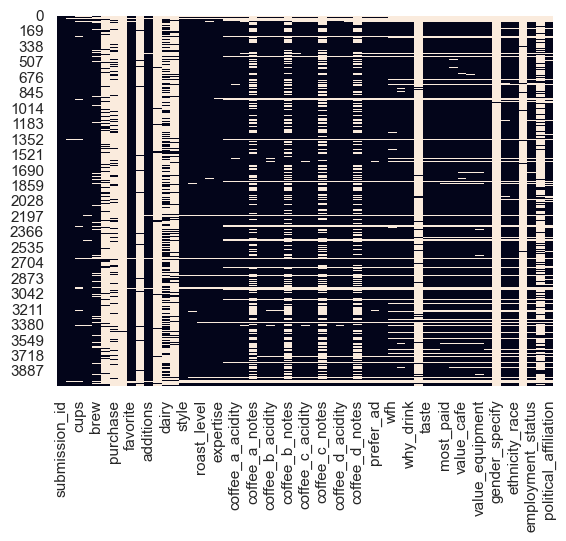

In [41]:
sns.heatmap(df.isnull(), cbar=False)


### Features that seem important
- target: roast_level

- age, cups, where_drink, brew, favorite, additions, dairy, style, caffeine, expertise, prefer_abc, prefer_ad, prefer_overall, wfh, total_spend, why_drink (im guessing people who drink for taste will like lighter roasts bc of specialty coffee), taste, know_source, most_paid, most_willing, value_cafe, spent_equipment, gender, education_level, ethnicity_race, employment_status, number_children, political_affiliation (use some sources for the report for this - liberal latte etc...)

- coffee abcd ratings (the tasting notes column is useful but i dont know how I could encode/quantify this since its so variable, but i think if someone is able to describe the notes in detail they are more likely to enjoy it)

- brew_other, purchase, sweetener -> could be useful but mostly null

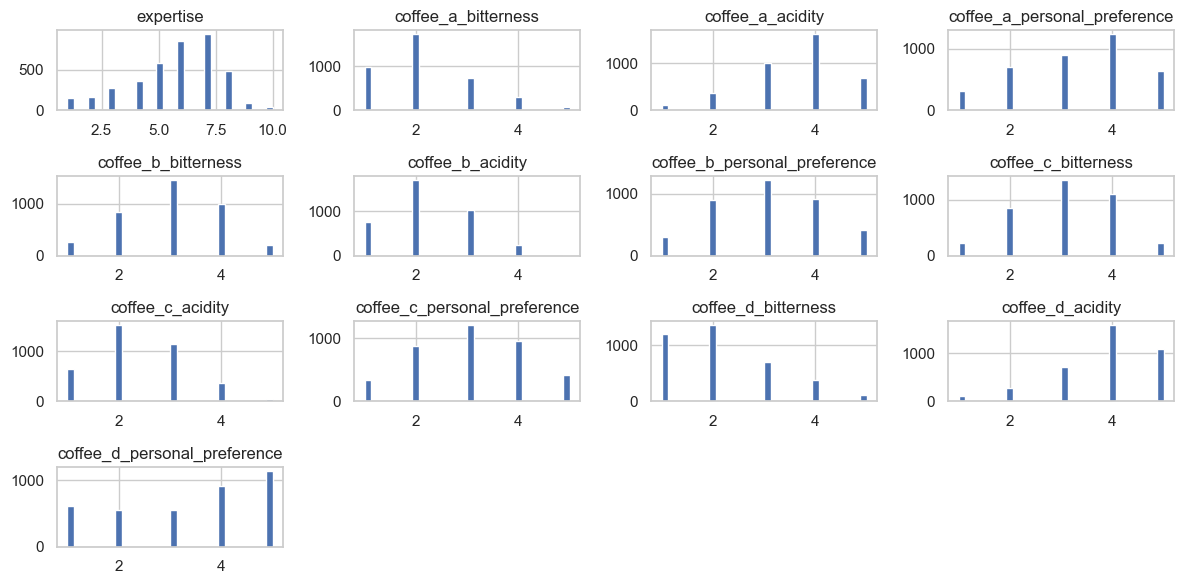

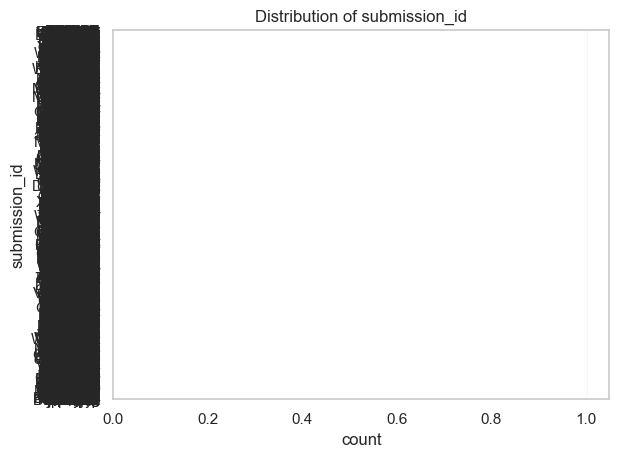

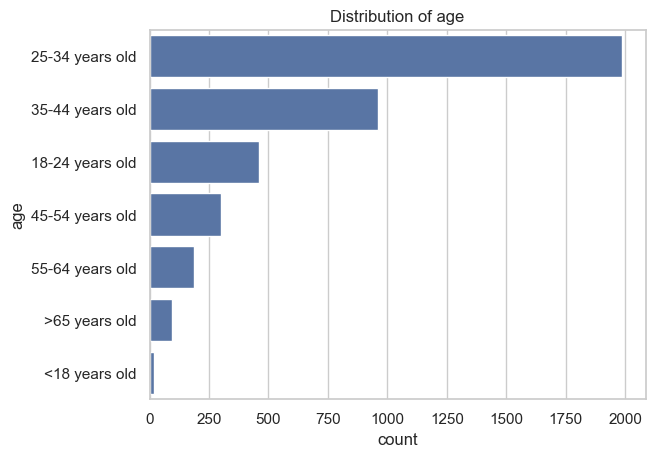

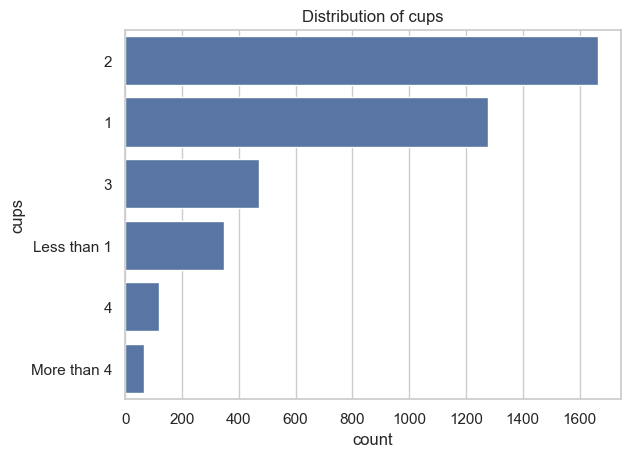

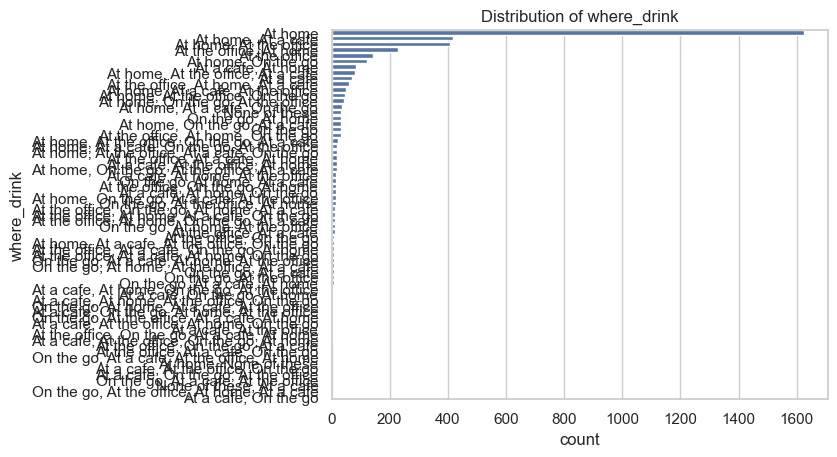

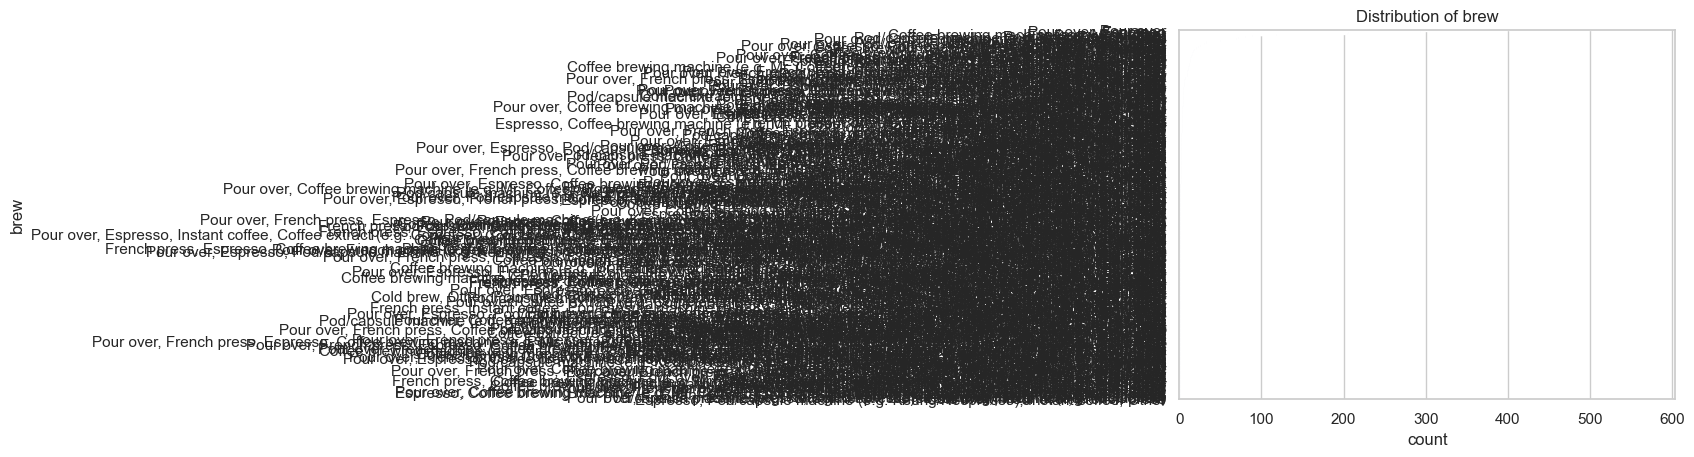

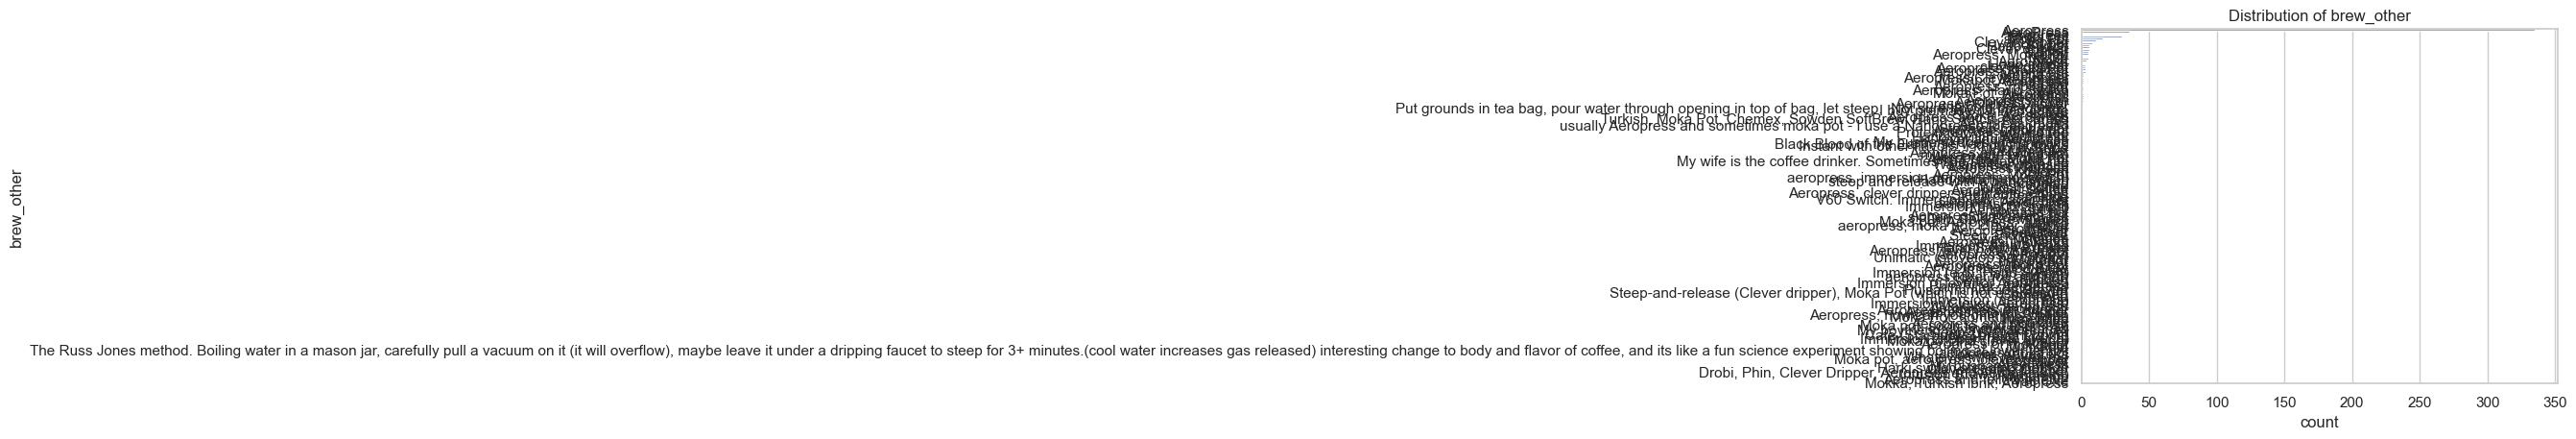

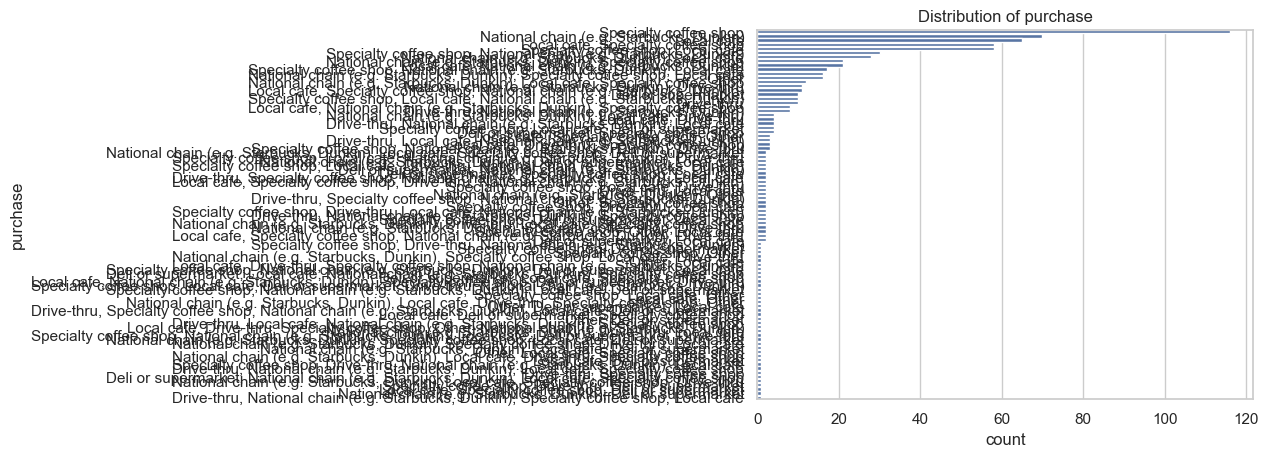

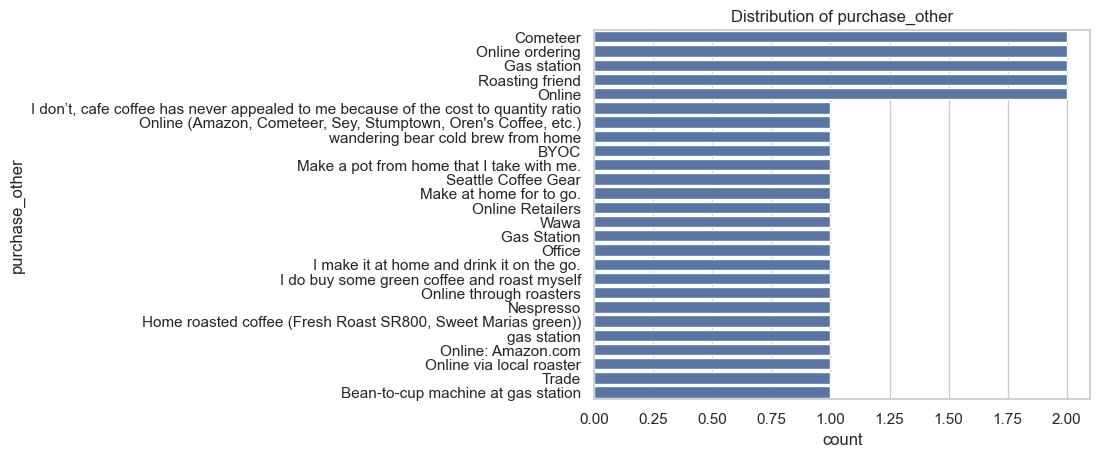

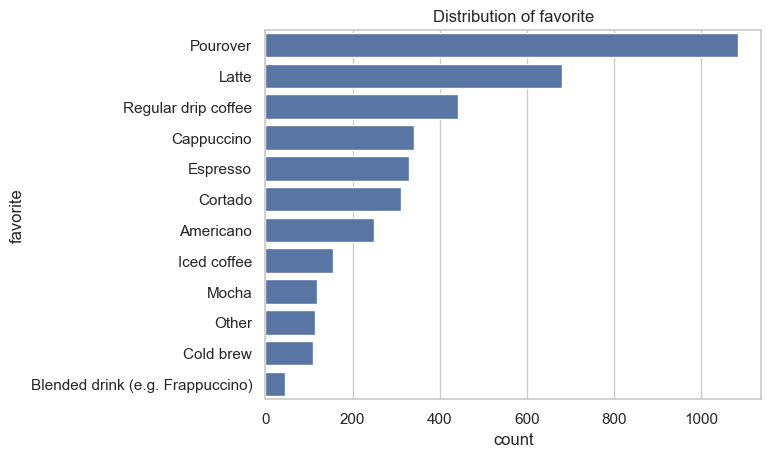

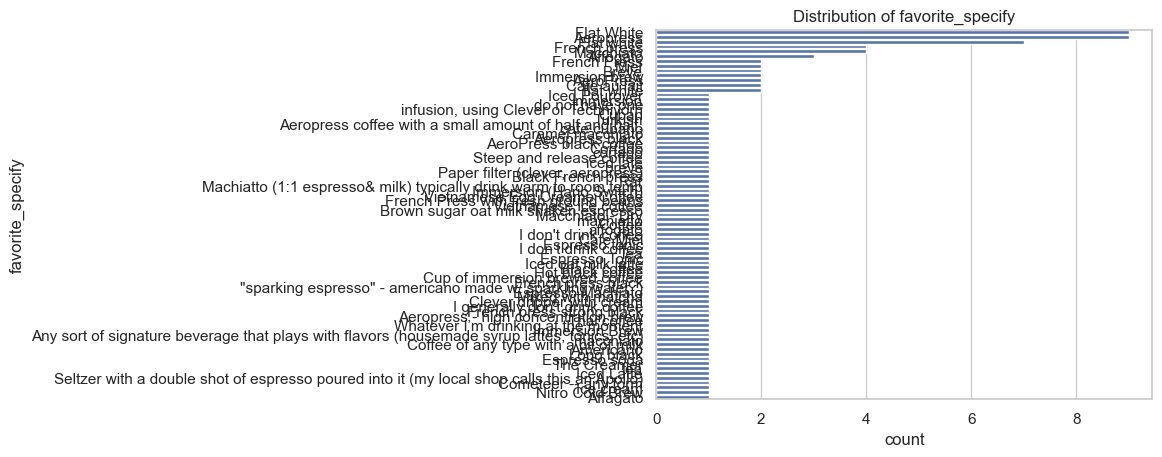

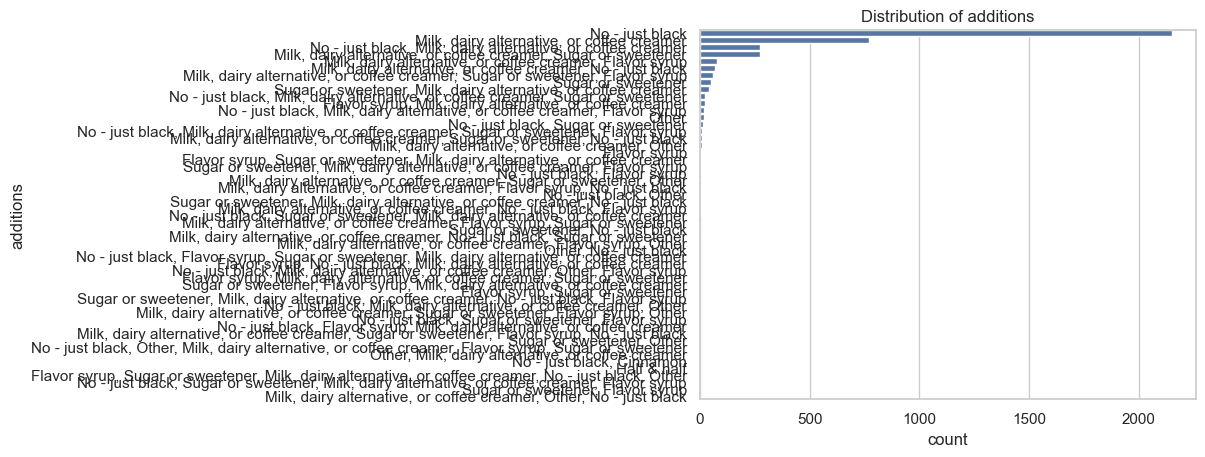

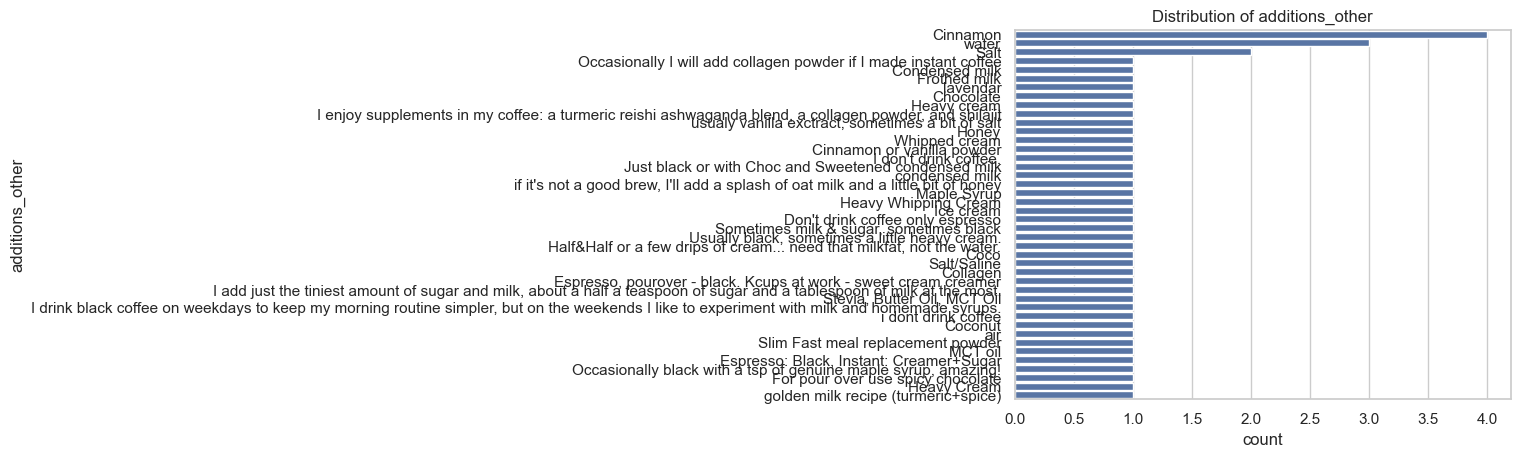

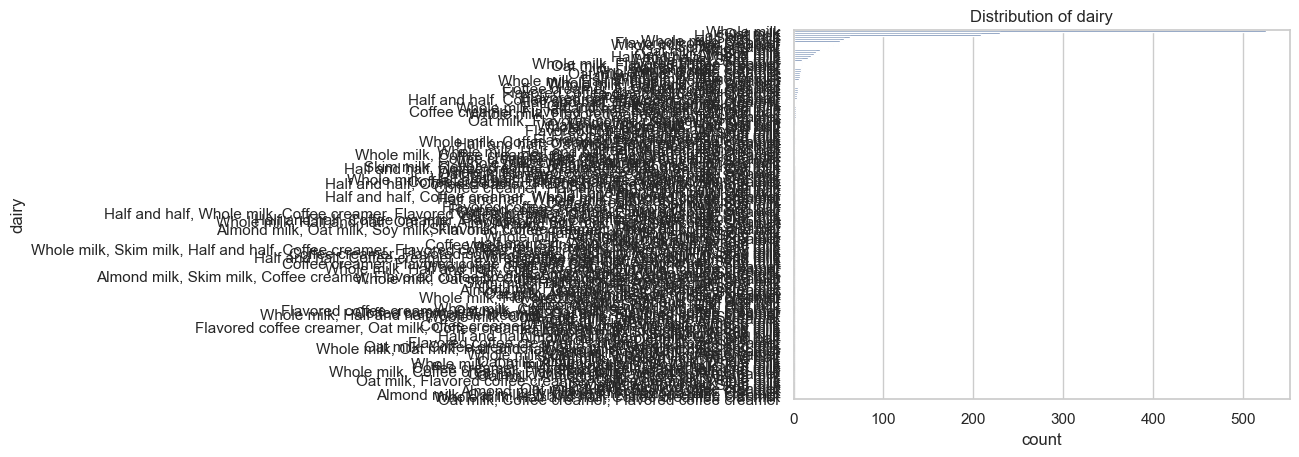

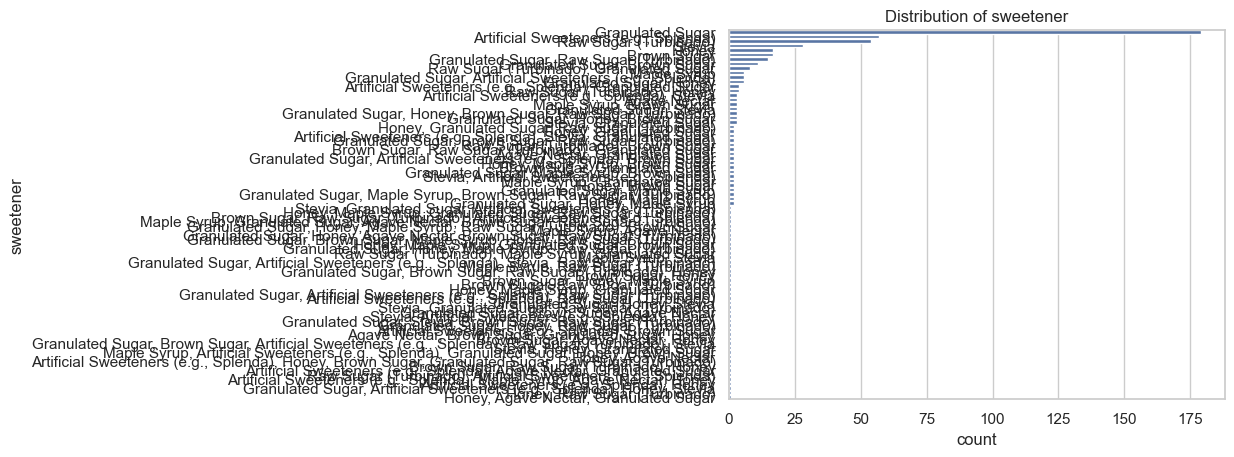

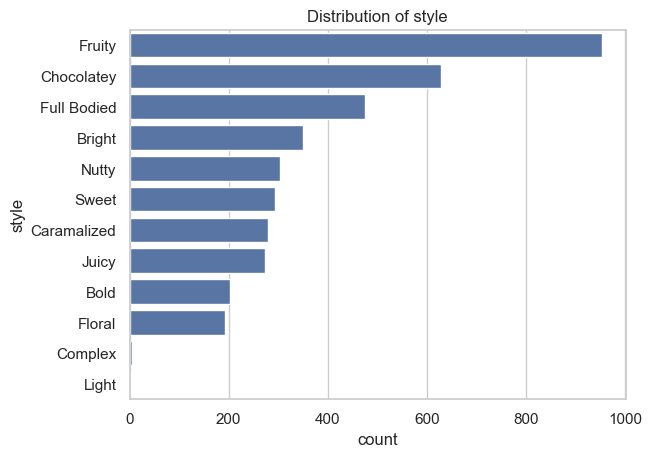

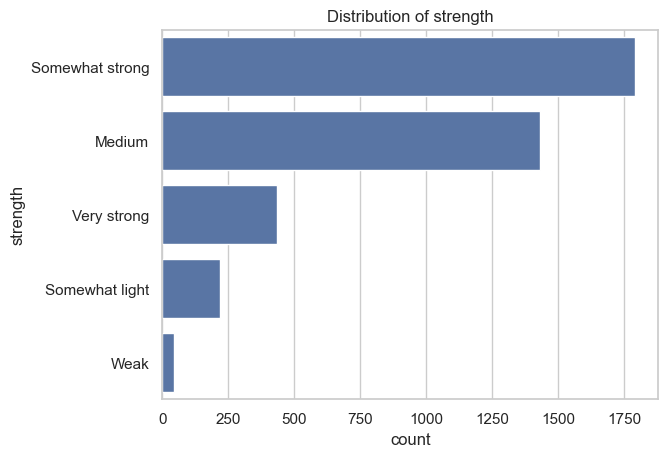

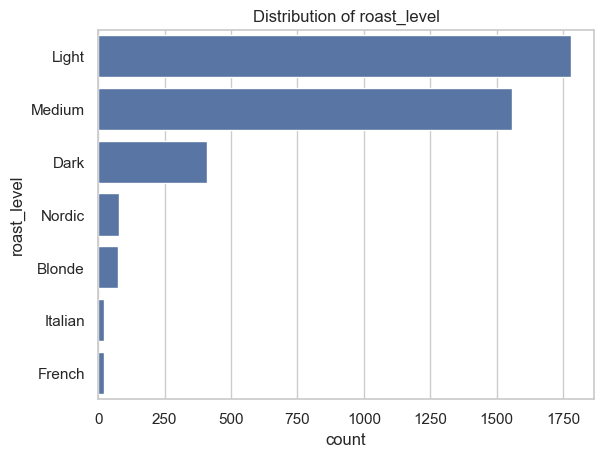

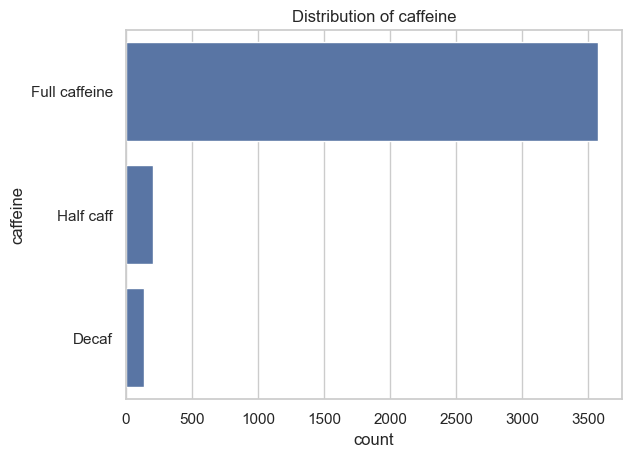

/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129335 (\N{SHRUG}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127995 (\N{EMOJI MODIFIER FITZPATRICK TYPE-1-2}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


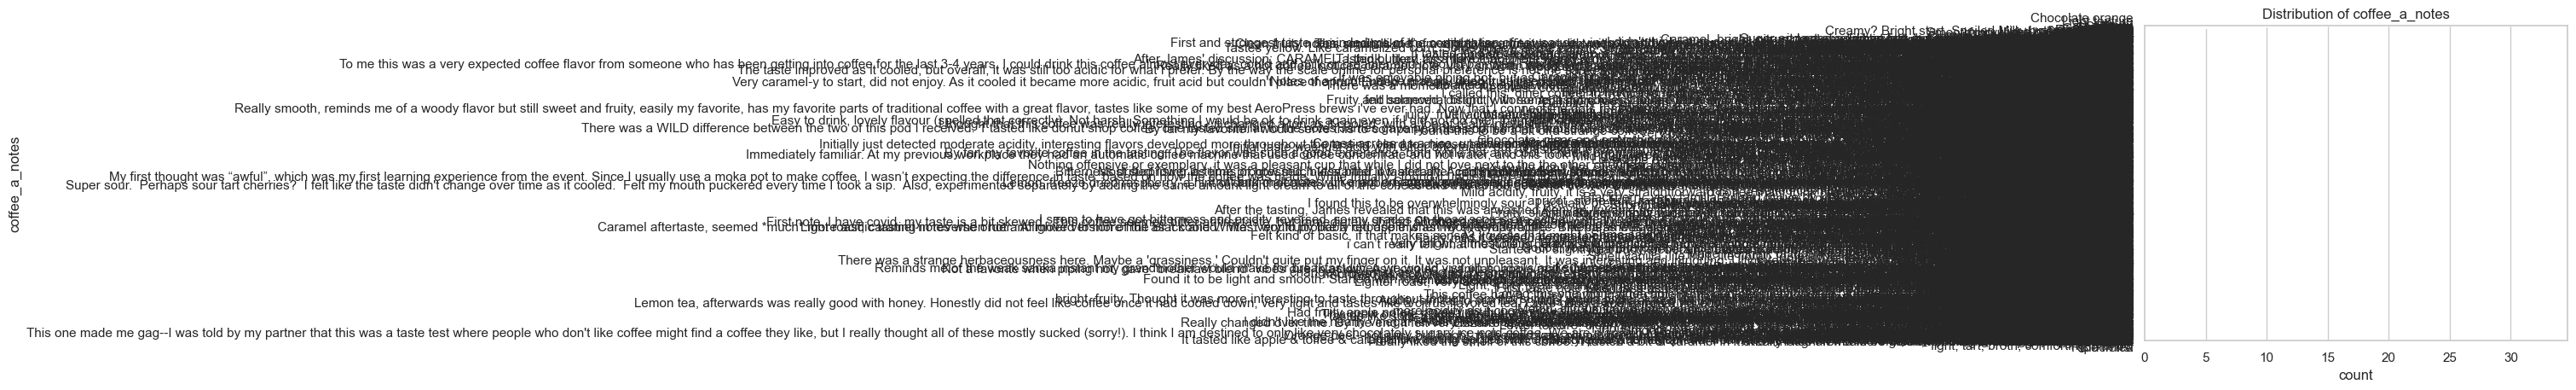

/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


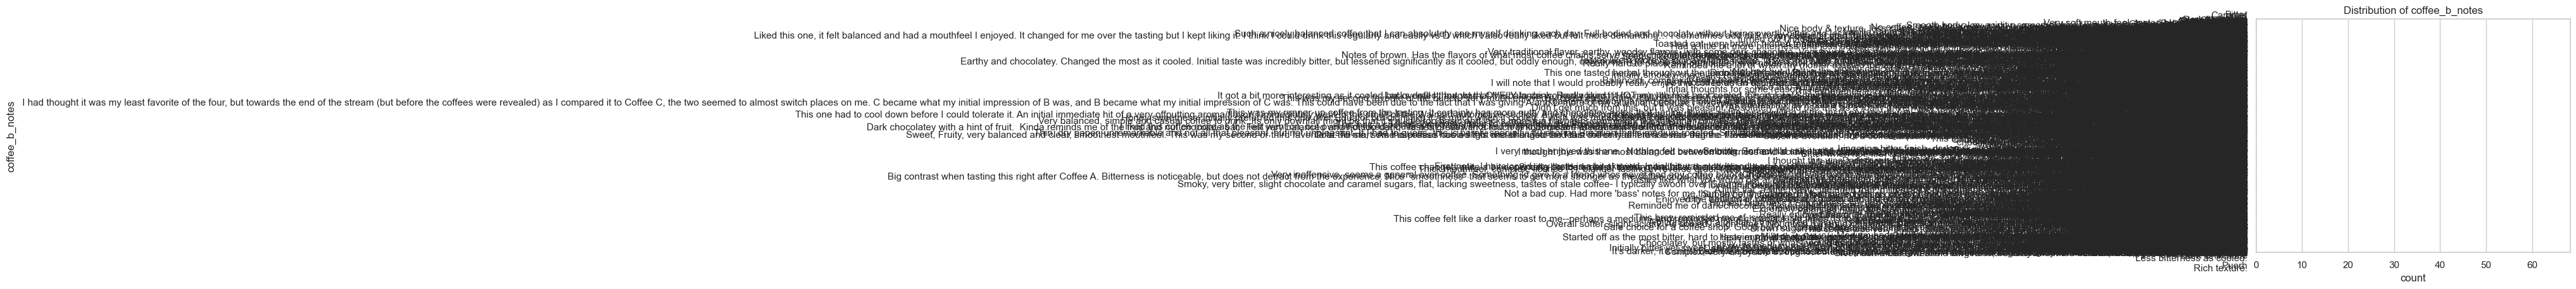

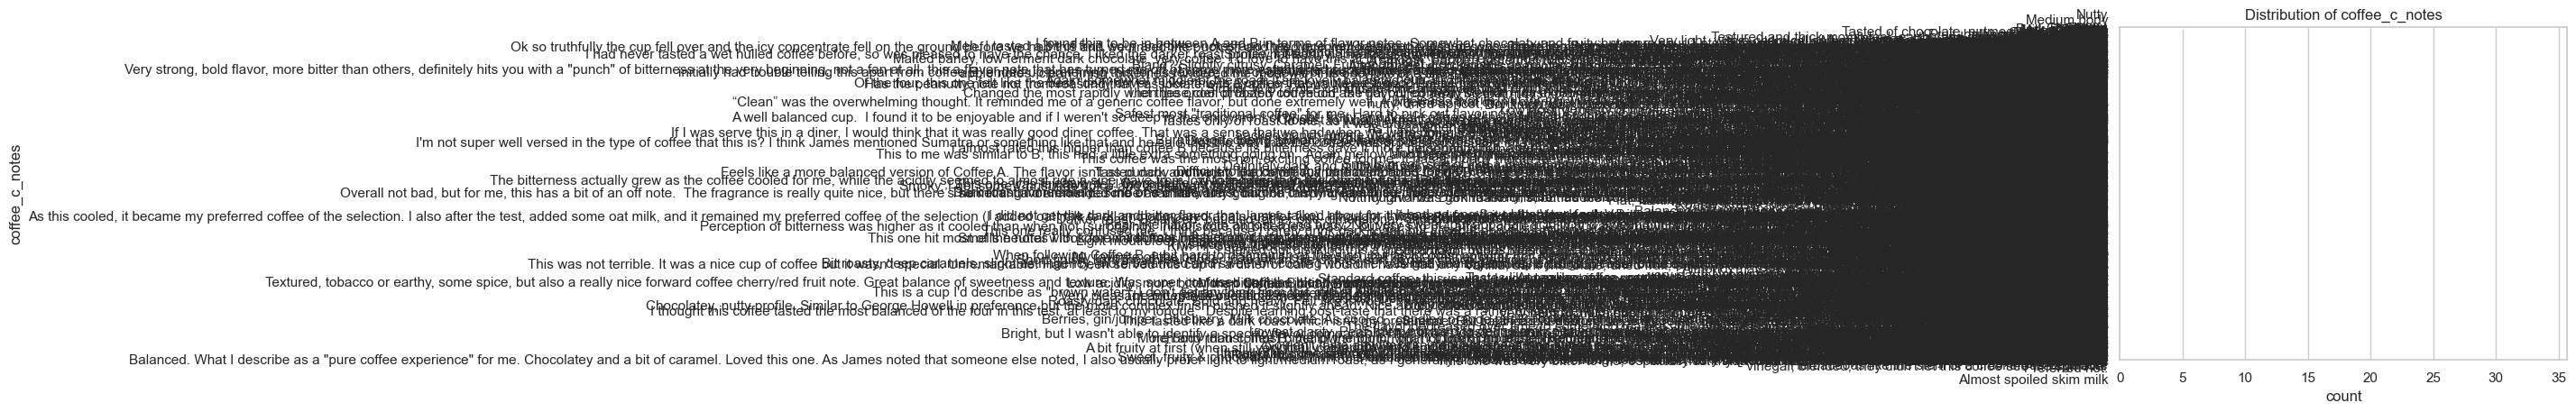

/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128150 (\N{SPARKLING HEART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128517 (\N{SMILING FACE WITH OPEN MOUTH AND COLD SWEAT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nigellobo/PycharmProjects/datasci3000/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127823 (\N{GREEN APPLE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


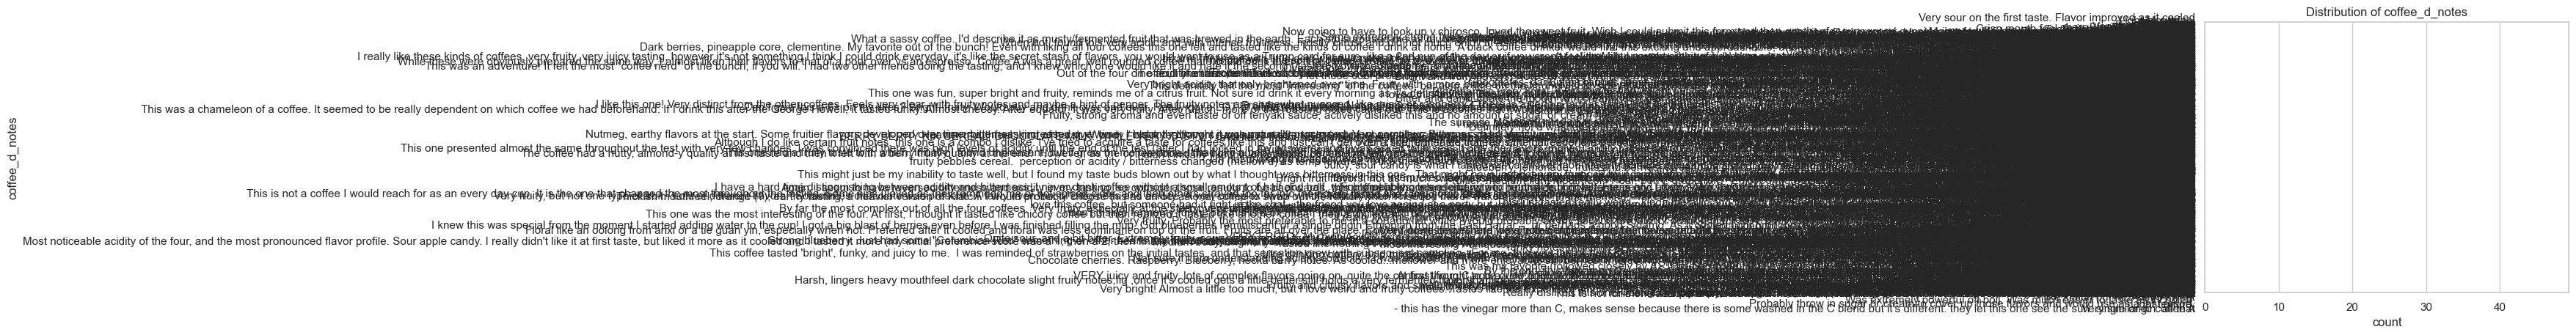

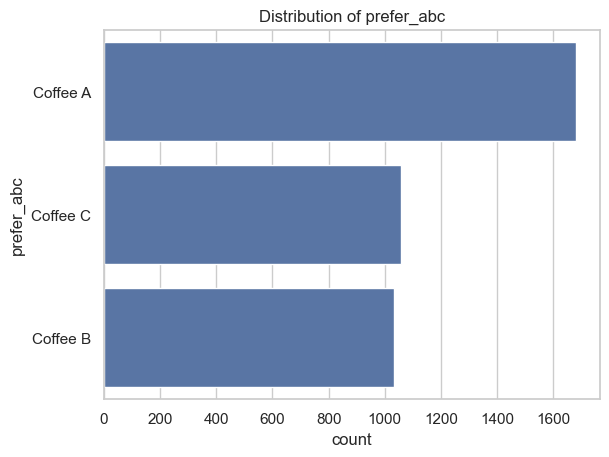

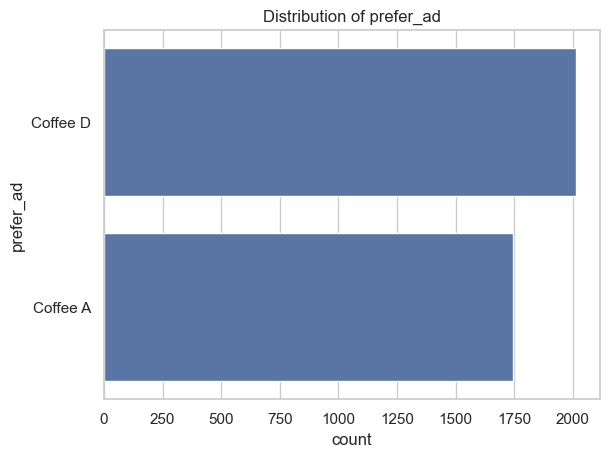

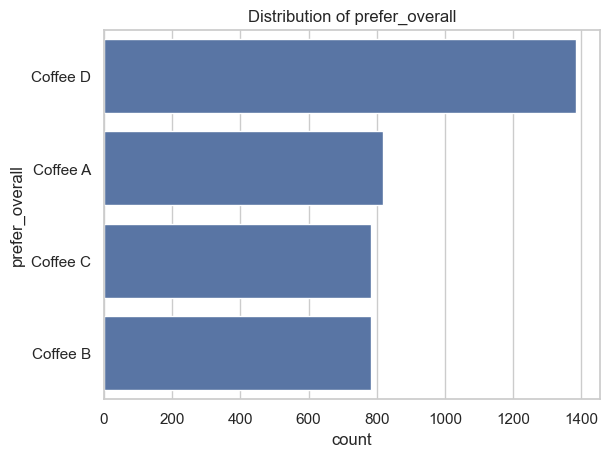

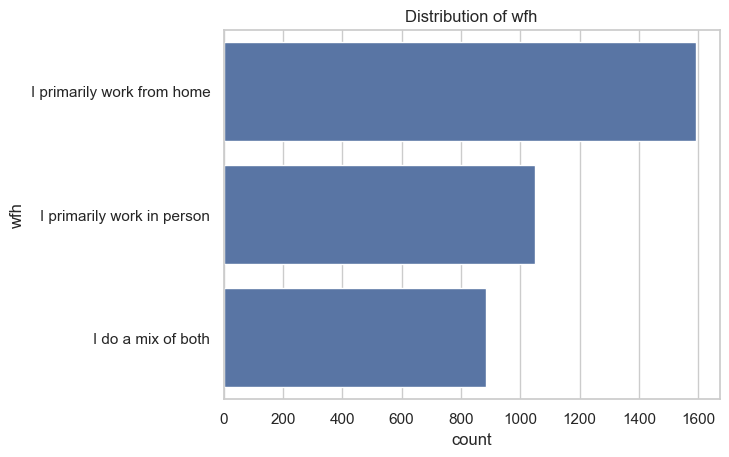

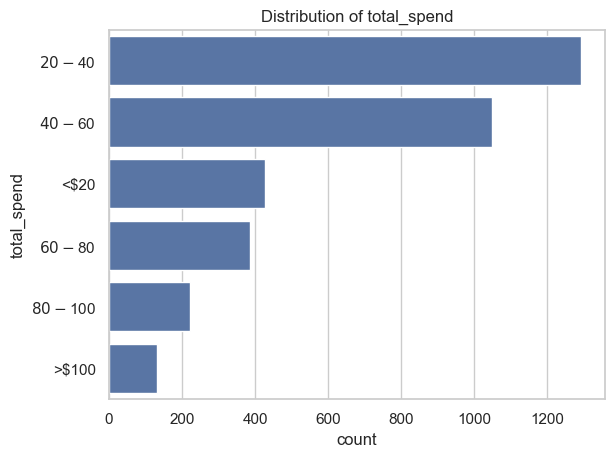

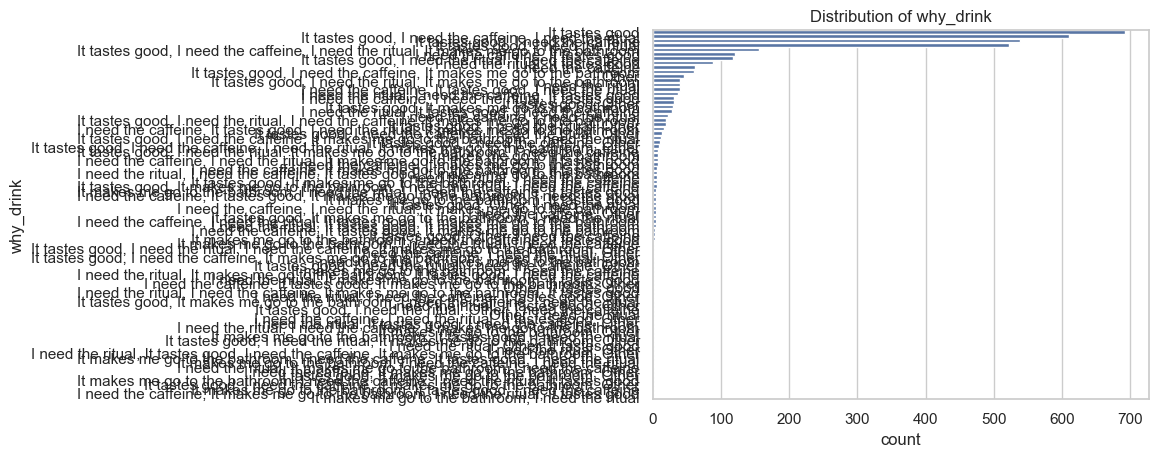

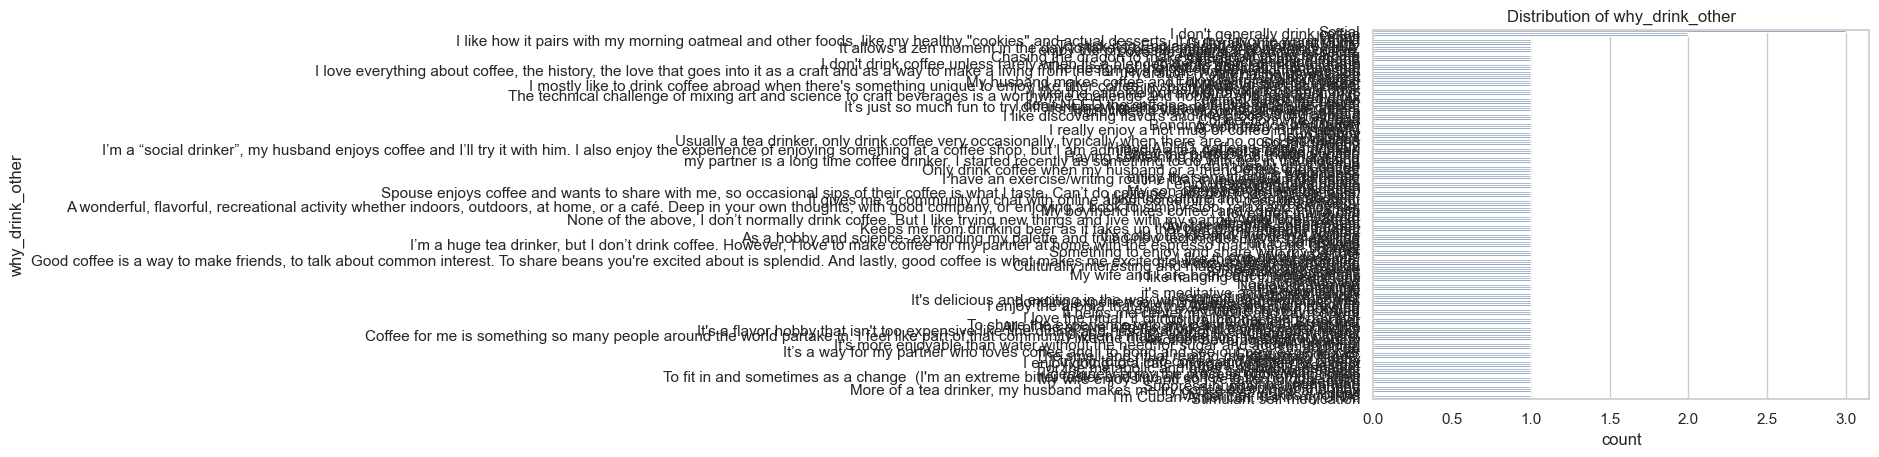

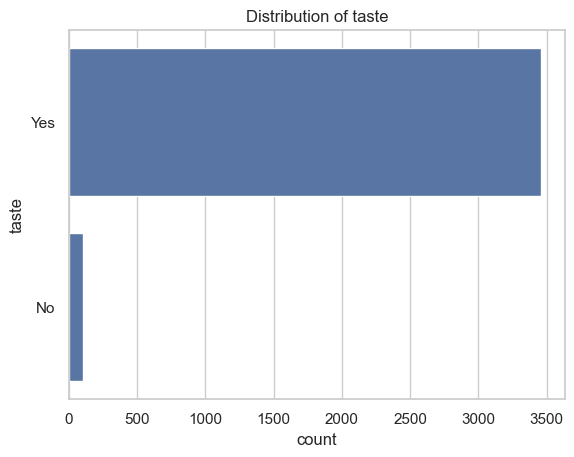

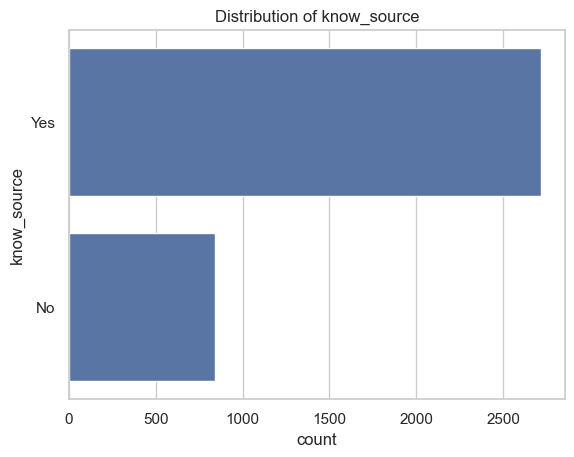

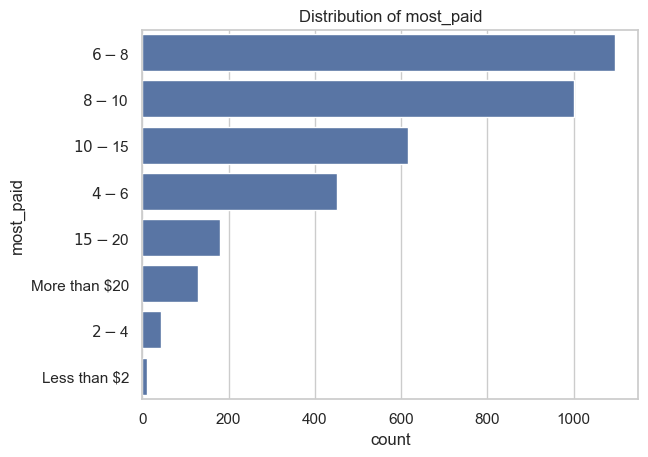

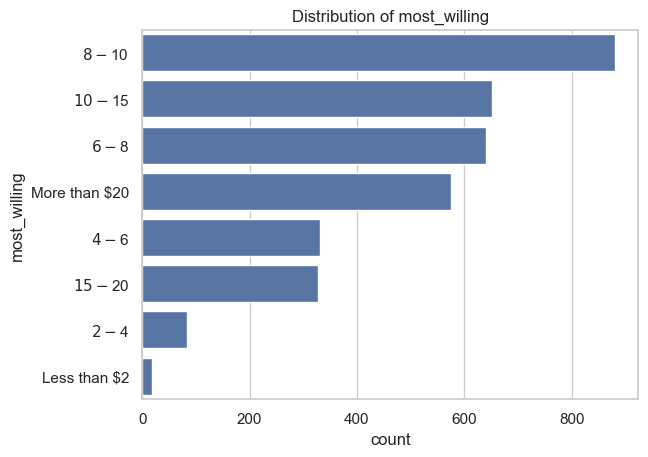

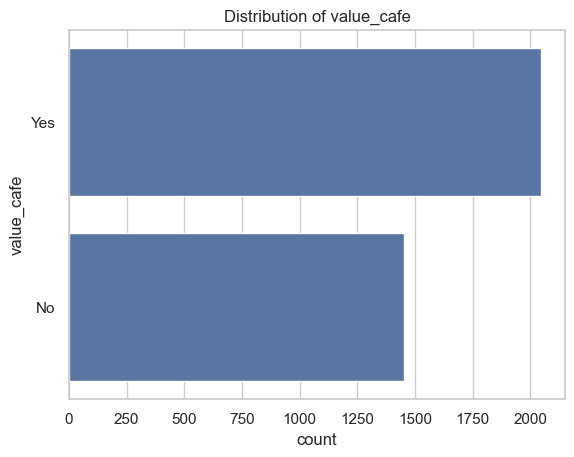

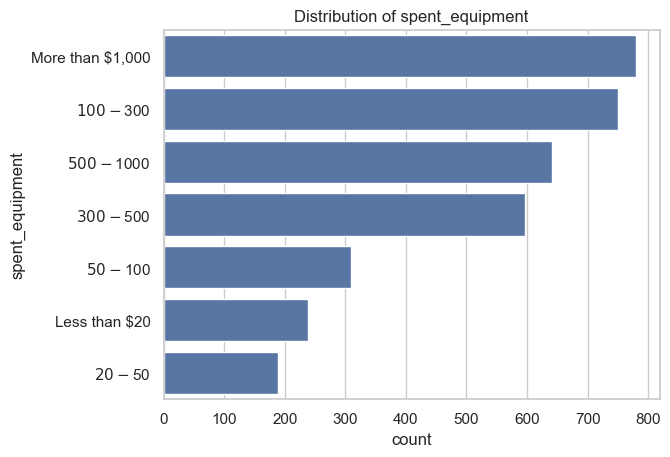

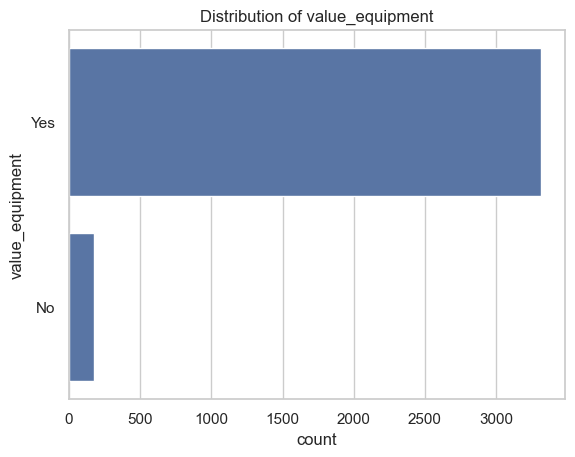

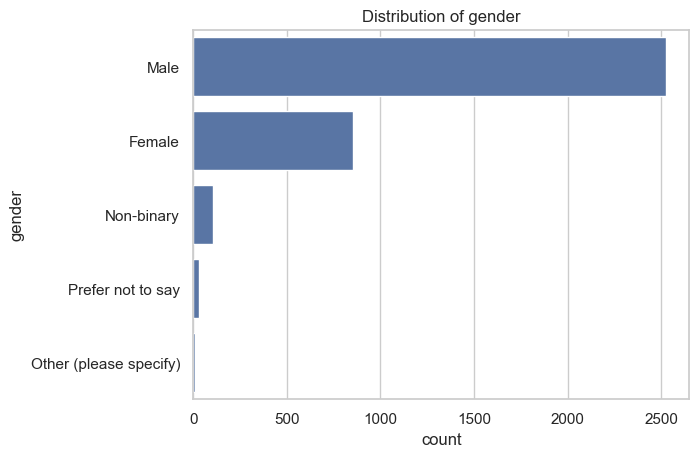

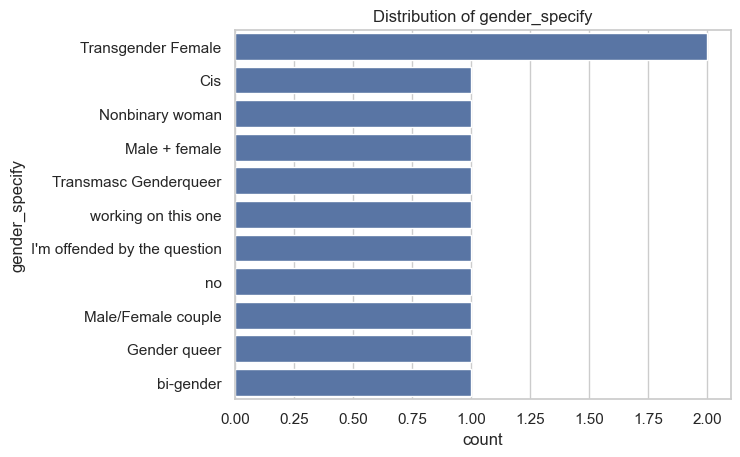

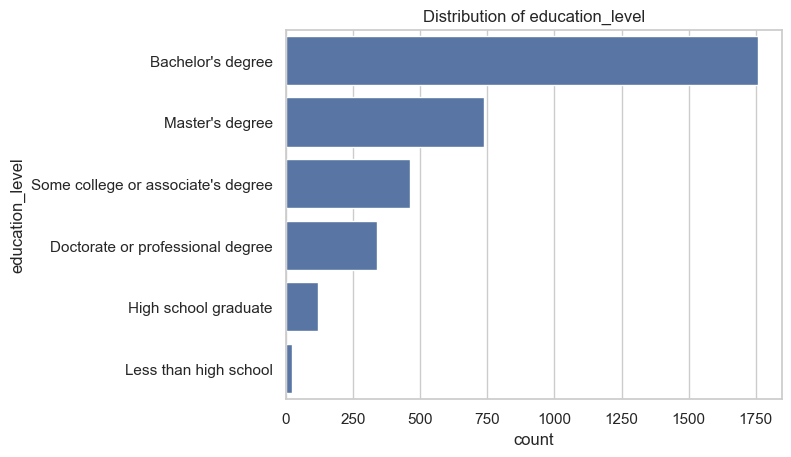

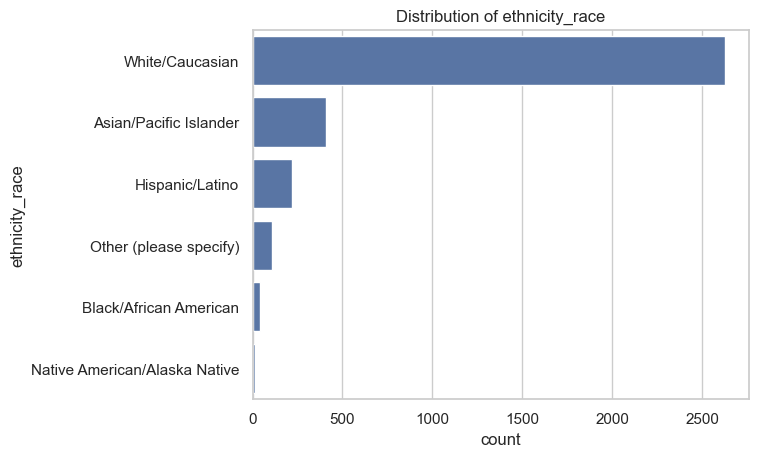

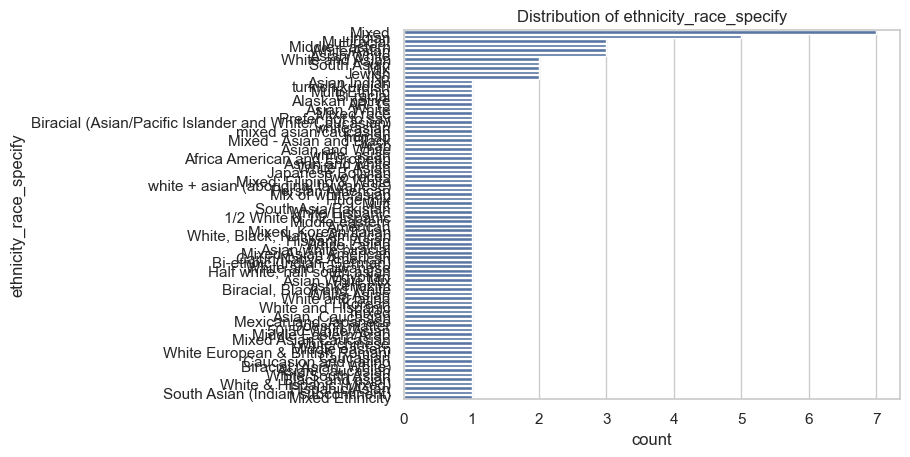

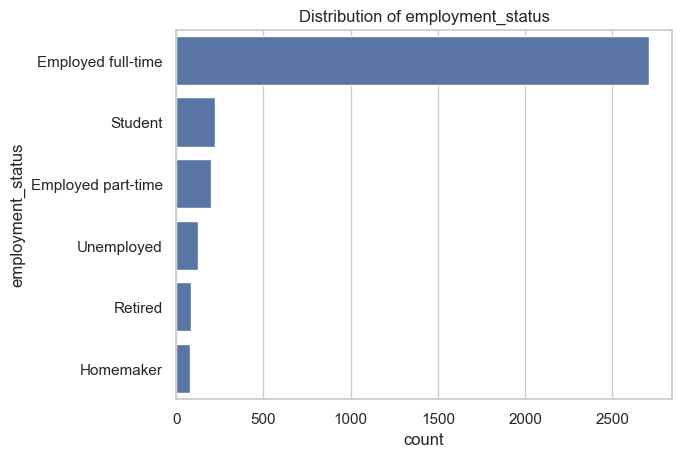

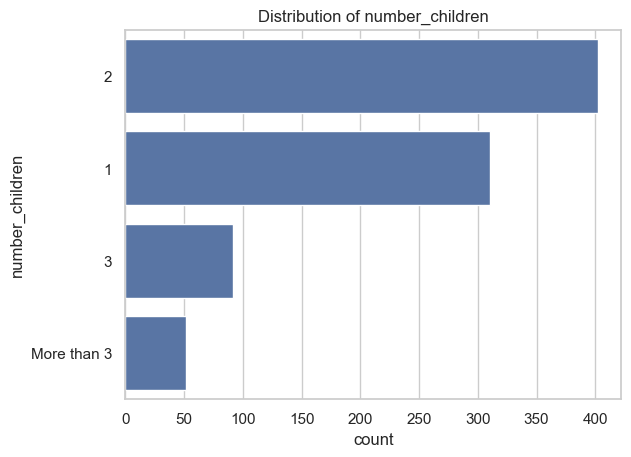

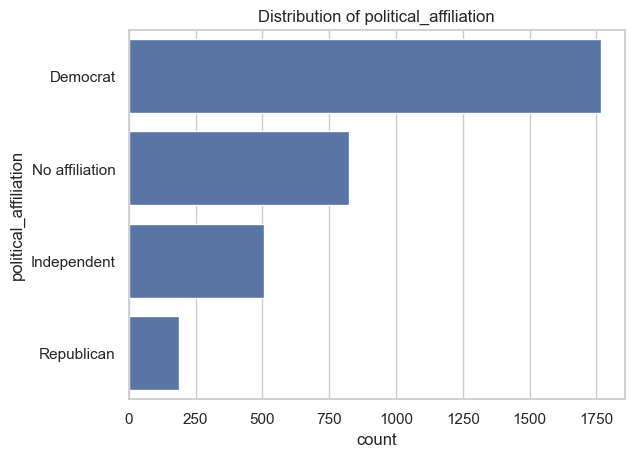

In [42]:
# distributions
num_cols = df.select_dtypes('number').columns
cat_cols = df.select_dtypes('object').columns

# Numeric
df[num_cols].hist(bins=30, figsize=(12, 6))
plt.tight_layout()
plt.show()

# Categorical
for col in cat_cols:
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()